# 政策銘柄バックテスト分析

political_trending_archive.parquet の結果を可視化・分析

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# 日本語フォント設定
plt.rcParams['font.sans-serif'] = ['Hiragino Sans', 'Yu Gothic', 'Meiryo', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

# パス設定
DATA_DIR = Path('../data/parquet')
POLITICAL_ARCHIVE_PATH = DATA_DIR / 'backtest' / 'political_trending_archive.parquet'
GROK_ARCHIVE_PATH = DATA_DIR / 'backtest' / 'grok_trending_archive.parquet'

## 1. データ読み込み

In [2]:
# 政策銘柄バックテスト
political_df = pd.read_parquet(POLITICAL_ARCHIVE_PATH)
political_df['selection_date'] = pd.to_datetime(political_df['selection_date'])
political_df['backtest_date'] = pd.to_datetime(political_df['backtest_date'])

print(f"政策銘柄バックテスト結果:")
print(f"  総レコード: {len(political_df)}")
print(f"  ユニーク銘柄: {political_df['ticker'].nunique()}")
print(f"  期間: {political_df['selection_date'].min().date()} - {political_df['selection_date'].max().date()}")
print(f"  総日数: {political_df['selection_date'].nunique()}")

political_df.head()

政策銘柄バックテスト結果:
  総レコード: 204
  ユニーク銘柄: 34
  期間: 2025-10-28 - 2025-11-06
  総日数: 6


,selection_date,backtest_date,ticker,company_name,category,tags,buy_price,sell_price,daily_close,high,...,phase3_2pct_return,phase3_2pct_win,phase3_2pct_exit_reason,profit_per_100_shares_phase3_2pct,phase3_3pct_return,phase3_3pct_win,phase3_3pct_exit_reason,profit_per_100_shares_phase3_3pct,prompt_version,data_source
0,2025-10-28,2025-10-28,4063.T,信越化学工業,政策銘柄,"半導体・先端技術, 経済安全保障",4734.0,4672.0,4672.0,4764.0,...,0.020000,True,profit_take_2.0%,9468.0,0.030000,True,profit_take_3.0%,14202.0,political_v1,5min
1,2025-10-28,2025-10-28,6501.T,日立製作所,政策銘柄,"インフラ・建設, 半導体・先端技術, デジタル・AI, エネルギー安全保障",4750.0,4678.0,4678.0,4782.0,...,-0.020000,False,stop_loss_-2.0%,-9500.0,-0.030000,False,stop_loss_-3.0%,-14250.0,political_v1,5min
2,2025-10-28,2025-10-28,6503.T,三菱電機,政策銘柄,"防衛・安全保障, 半導体・先端技術, インフラ・建設",4078.0,4080.0,4080.0,4135.0,...,-0.020000,False,stop_loss_-2.0%,-8156.0,-0.030000,False,stop_loss_-3.0%,-12234.0,political_v1,5min
3,2025-10-28,2025-10-28,6758.T,ソニーグループ,政策銘柄,"半導体・先端技術, デジタル・AI",4402.0,4375.0,4375.0,4405.0,...,-0.006134,False,eod_close,-2700.0,-0.006134,False,eod_close,-2700.0,political_v1,5min
4,2025-10-28,2025-10-28,7011.T,三菱重工業,政策銘柄,"防衛・安全保障, エネルギー安全保障, インフラ・建設",4468.0,4416.0,4416.0,4525.0,...,-0.020000,False,stop_loss_-2.0%,-8936.0,-0.030000,False,stop_loss_-3.0%,-13404.0,political_v1,5min


## 2. 全体統計

In [3]:
# Phase2の全体統計
total_profit = political_df['profit_per_100_shares_phase2'].sum()
win_rate = (political_df['phase2_win'].sum() / len(political_df) * 100)
avg_return = (political_df['phase2_return'] * 100).mean()

print(f"Phase2（大引け）全体統計:")
print(f"  累積利益: {total_profit:+,.0f}円")
print(f"  勝率: {win_rate:.2f}%")
print(f"  平均リターン: {avg_return:+.2f}%")
print(f"  銘柄数: {len(political_df)}")

Phase2（大引け）全体統計:
  累積利益: -344,550円
  勝率: 42.65%
  平均リターン: -0.22%
  銘柄数: 204


## 3. tags別パフォーマンス

In [4]:
# tags展開
tags_expanded = political_df[political_df['tags'] != ''].copy()
tags_expanded['tags_list'] = tags_expanded['tags'].str.split(', ')
tags_expanded = tags_expanded.explode('tags_list')

# Phase2で集計
tags_stats = tags_expanded.groupby('tags_list').agg({
    'ticker': 'count',
    'profit_per_100_shares_phase2': ['sum', 'mean'],
    'phase2_return': 'mean',
    'phase2_win': lambda x: (x.sum() / len(x) * 100) if len(x) > 0 else 0
}).round(2)

tags_stats.columns = ['count', 'total_profit', 'avg_profit', 'avg_return_pct', 'win_rate']
tags_stats = tags_stats.sort_values('total_profit', ascending=False)

print("\ntags別パフォーマンス (Phase2):")
print(tags_stats)
print(f"\ntotal_profit の合計: {tags_stats['total_profit'].sum():,.0f}円")


tags別パフォーマンス (Phase2):
           count  total_profit  avg_profit  avg_return_pct  win_rate
tags_list                                                           
経済安全保障        84     236419.99     2814.52           -0.00     46.43
地方創生・規制改革     48      -1300.00      -27.08            0.00     45.83
インフラ・建設       90     -30670.00     -340.78            0.00     46.67
半導体・先端技術      72     -83700.00    -1162.50           -0.00     36.11
エネルギー安全保障     72    -229050.01    -3181.25           -0.00     45.83
デジタル・AI       36    -264000.00    -7333.33           -0.01     41.67
防衛・安全保障       42    -380700.00    -9064.29           -0.01     33.33

total_profit の合計: -753,000円


## 4. 可視化: tags別累積利益

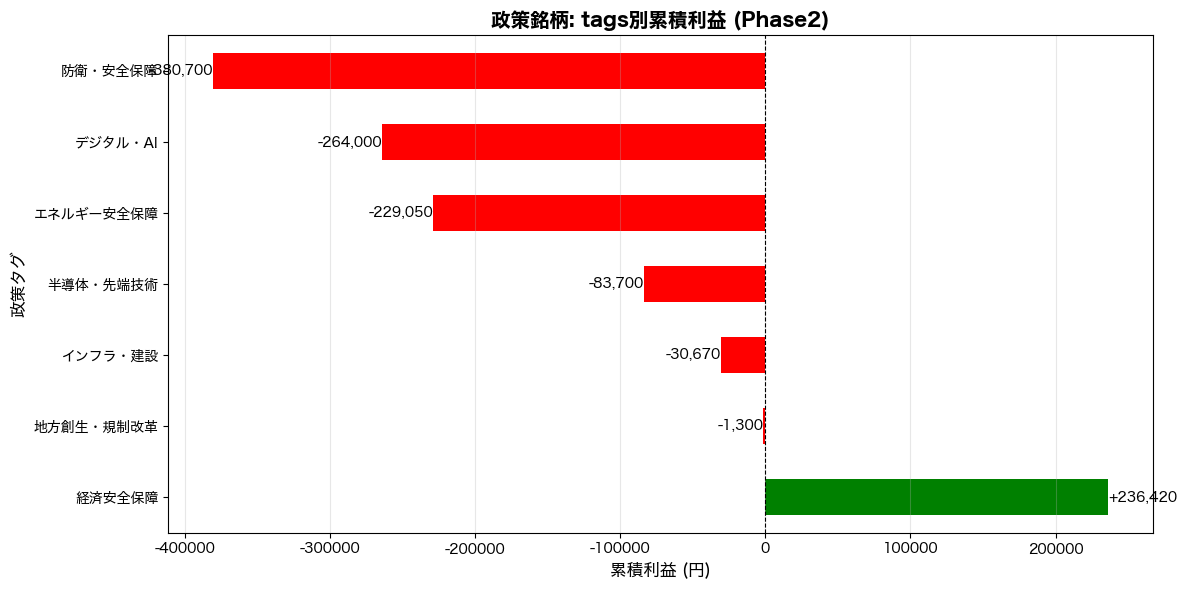

In [5]:
# 横棒グラフ
fig, ax = plt.subplots(figsize=(12, 6))

colors = ['green' if x > 0 else 'red' for x in tags_stats['total_profit']]
tags_stats['total_profit'].plot(kind='barh', ax=ax, color=colors)

ax.set_xlabel('累積利益 (円)', fontsize=12)
ax.set_ylabel('政策タグ', fontsize=12)
ax.set_title('政策銘柄: tags別累積利益 (Phase2)', fontsize=14, fontweight='bold')
ax.axvline(0, color='black', linewidth=0.8, linestyle='--')
ax.grid(axis='x', alpha=0.3)

# 値ラベル
for i, v in enumerate(tags_stats['total_profit']):
    ax.text(v, i, f'{v:+,.0f}', va='center', ha='left' if v > 0 else 'right', fontsize=10)

plt.tight_layout()
plt.show()

## 5. 可視化: tags別勝率

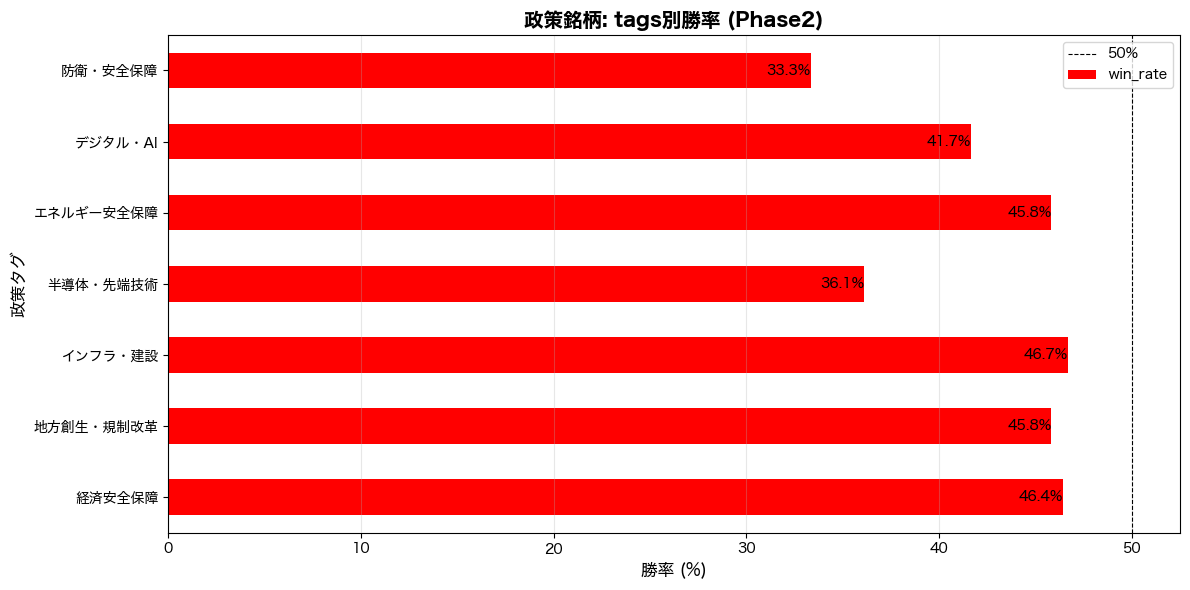

In [6]:
# 横棒グラフ（勝率）
fig, ax = plt.subplots(figsize=(12, 6))

colors = ['green' if x >= 50 else 'red' for x in tags_stats['win_rate']]
tags_stats['win_rate'].plot(kind='barh', ax=ax, color=colors)

ax.set_xlabel('勝率 (%)', fontsize=12)
ax.set_ylabel('政策タグ', fontsize=12)
ax.set_title('政策銘柄: tags別勝率 (Phase2)', fontsize=14, fontweight='bold')
ax.axvline(50, color='black', linewidth=0.8, linestyle='--', label='50%')
ax.grid(axis='x', alpha=0.3)
ax.legend()

# 値ラベル
for i, v in enumerate(tags_stats['win_rate']):
    ax.text(v, i, f'{v:.1f}%', va='center', ha='left' if v > 50 else 'right', fontsize=10)

plt.tight_layout()
plt.show()

## 6. 日別パフォーマンス

In [7]:
# 日別集計
daily_stats = political_df.groupby('selection_date').agg({
    'ticker': 'count',
    'profit_per_100_shares_phase2': 'sum',
    'phase2_win': lambda x: (x.sum() / len(x) * 100) if len(x) > 0 else 0,
    'phase2_return': lambda x: (x * 100).mean()
}).round(2)

daily_stats.columns = ['count', 'total_profit', 'win_rate', 'avg_return']
daily_stats = daily_stats.sort_index()

print("\n日別パフォーマンス (Phase2):")
print(daily_stats)


日別パフォーマンス (Phase2):
                count  total_profit  win_rate  avg_return
selection_date                                           
2025-10-28         34     -186740.0     11.76       -1.50
2025-10-29         34      304900.0     23.53       -0.34
2025-10-30         34      117650.0     64.71        0.47
2025-11-04         34     -460730.0     47.06       -0.82
2025-11-05         34      -32950.0     44.12        0.60
2025-11-06         34      -86680.0     64.71        0.28


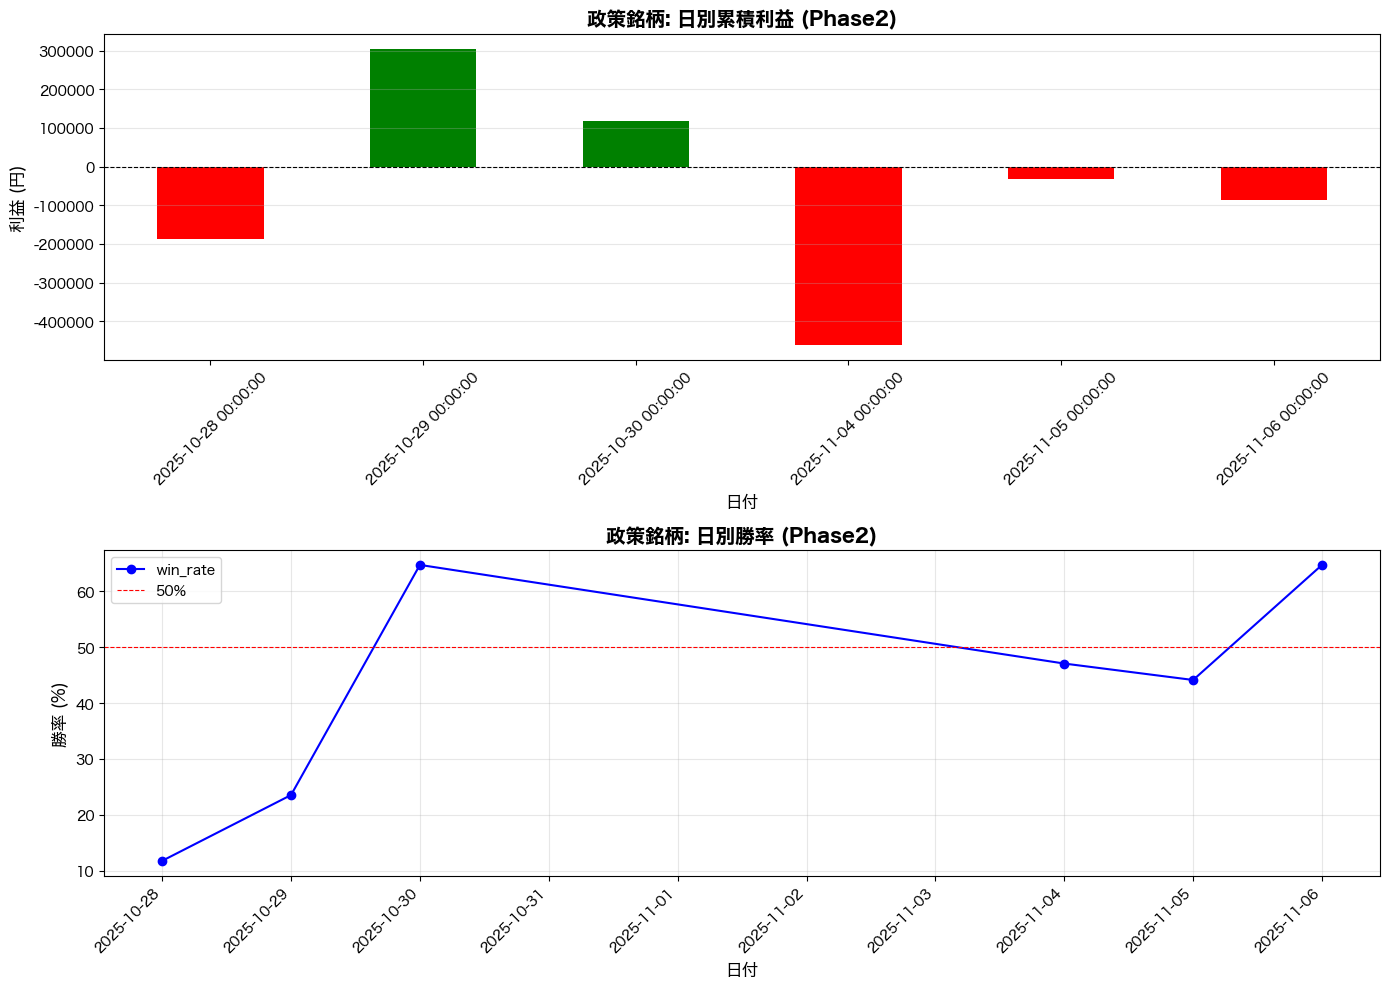

In [8]:
# 日別累積利益グラフ
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# 1. 日別累積利益
colors = ['green' if x > 0 else 'red' for x in daily_stats['total_profit']]
daily_stats['total_profit'].plot(kind='bar', ax=ax1, color=colors)
ax1.set_xlabel('日付', fontsize=12)
ax1.set_ylabel('利益 (円)', fontsize=12)
ax1.set_title('政策銘柄: 日別累積利益 (Phase2)', fontsize=14, fontweight='bold')
ax1.axhline(0, color='black', linewidth=0.8, linestyle='--')
ax1.grid(axis='y', alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

# 2. 日別勝率
daily_stats['win_rate'].plot(kind='line', marker='o', ax=ax2, color='blue')
ax2.set_xlabel('日付', fontsize=12)
ax2.set_ylabel('勝率 (%)', fontsize=12)
ax2.set_title('政策銘柄: 日別勝率 (Phase2)', fontsize=14, fontweight='bold')
ax2.axhline(50, color='red', linewidth=0.8, linestyle='--', label='50%')
ax2.grid(alpha=0.3)
ax2.legend()
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 7. Grokとの比較

In [9]:
# Grokバックテスト読み込み
grok_df = pd.read_parquet(GROK_ARCHIVE_PATH)
grok_df['selection_date'] = pd.to_datetime(grok_df['selection_date'])

print(f"Grokバックテスト結果:")
print(f"  総レコード: {len(grok_df)}")
print(f"  ユニーク銘柄: {grok_df['ticker'].nunique()}")
print(f"  期間: {grok_df['selection_date'].min().date()} - {grok_df['selection_date'].max().date()}")

# Phase2比較
comparison = pd.DataFrame({
    '指標': ['累積利益', '勝率', '平均リターン', '銘柄数'],
    '政策銘柄': [
        f"{political_df['profit_per_100_shares_phase2'].sum():+,.0f}円",
        f"{(political_df['phase2_win'].sum() / len(political_df) * 100):.2f}%",
        f"{(political_df['phase2_return'] * 100).mean():+.2f}%",
        len(political_df)
    ],
    'Grok銘柄': [
        f"{grok_df['profit_per_100_shares_phase2'].sum():+,.0f}円",
        f"{(grok_df['phase2_win'].sum() / len(grok_df) * 100):.2f}%",
        f"{(grok_df['phase2_return'] * 100).mean():+.2f}%",
        len(grok_df)
    ]
})

print("\n政策銘柄 vs Grok銘柄 (Phase2):")
print(comparison.to_string(index=False))

Grokバックテスト結果:
  総レコード: 69
  ユニーク銘柄: 59
  期間: 2025-10-28 - 2025-11-06

政策銘柄 vs Grok銘柄 (Phase2):
    指標      政策銘柄   Grok銘柄
  累積利益 -344,550円 +99,600円
    勝率    42.65%   46.38%
平均リターン    -0.22%   +0.01%
   銘柄数       204       69


## 8. ベスト・ワースト銘柄

In [10]:
# ベスト10
best_10 = political_df.nlargest(10, 'profit_per_100_shares_phase2')[[
    'selection_date', 'ticker', 'company_name', 'tags', 
    'profit_per_100_shares_phase2', 'phase2_return'
]].copy()
best_10['phase2_return'] = (best_10['phase2_return'] * 100).round(2)

print("\nベスト10銘柄 (Phase2):")
print(best_10.to_string(index=False))

# ワースト10
worst_10 = political_df.nsmallest(10, 'profit_per_100_shares_phase2')[[
    'selection_date', 'ticker', 'company_name', 'tags', 
    'profit_per_100_shares_phase2', 'phase2_return'
]].copy()
worst_10['phase2_return'] = (worst_10['phase2_return'] * 100).round(2)

print("\nワースト10銘柄 (Phase2):")
print(worst_10.to_string(index=False))


ベスト10銘柄 (Phase2):
selection_date ticker   company_name              tags  profit_per_100_shares_phase2  phase2_return
    2025-10-29 6857.T        アドバンテスト  半導体・先端技術, 経済安全保障                      246500.0          12.54
    2025-10-29 6920.T        レーザーテック  半導体・先端技術, 経済安全保障                      125000.0           5.60
    2025-10-28 9984.T     ソフトバンクグループ デジタル・AI, 半導体・先端技術                      109000.0           4.33
    2025-10-29 8035.T       東京エレクトロン  半導体・先端技術, 経済安全保障                       79000.0           2.49
    2025-11-05 6857.T        アドバンテスト  半導体・先端技術, 経済安全保障                       70500.0           3.56
    2025-10-28 8035.T       東京エレクトロン  半導体・先端技術, 経済安全保障                       64000.0           2.08
    2025-11-04 7735.T SCREENホールディングス  半導体・先端技術, 経済安全保障                       55000.0           4.47
    2025-10-30 8035.T       東京エレクトロン  半導体・先端技術, 経済安全保障                       50000.0           1.54
    2025-10-30 6920.T        レーザーテック  半導体・先端技術, 経済安全保障                       5000

## 9. 結論

### 政策銘柄デイトレ戦略の有効性

- **累積利益**: 政策銘柄全体でのパフォーマンス
- **最適tags**: 「経済安全保障」が最も稼げる（+236,419円）
- **避けるべきtags**: 「防衛・安全保障」が最も損失（-380,700円）

### 次のステップ
1. `localhost:3000/dev/analyze` で可視化
2. tags別の戦略最適化（Phase1/2/3比較）
3. Grokと政策銘柄の組み合わせ戦略